### Imports

In [1]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from pydantic import BaseModel, Field
from typing import TypedDict, Literal
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

### LLM

In [3]:
model = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

In [4]:
class SentimentSchema(BaseModel):
    sentiment: Literal["positive", "negative"] = Field(
        description="Sentiment of the review"
    )

In [5]:
structured_model = model.with_structured_output(SentimentSchema)

In [6]:
prompt = "What is the sentiment of this review - The software is great, I love it!"
structured_model.invoke(prompt)

SentimentSchema(sentiment='positive')

In [7]:
class diagnosisSchema(BaseModel):
    issue_type: str = Field(description="Type of issue")
    tone: str = Field(description="Tone of the reply")
    urgency: str = Field(description="Urgency of the issue")

In [8]:
diagnosis_model = model.with_structured_output(diagnosisSchema)

In [9]:
prompt = "Diagnose this negative review based on the issue type, tone and urgency - The software hangs a bit."
diagnosis_model.invoke(prompt)

diagnosisSchema(issue_type='Performance Issue', tone='Neutral', urgency='Medium')

### State

In [10]:
class ReviewReplyState(TypedDict):
    review: str
    sentiment: Literal["positive", "negative"]
    diagnosis: dict
    reply: str

### Node Functions

In [11]:
def get_sentiment(state: ReviewReplyState) -> ReviewReplyState:
    prompt = f"What is the sentiment of this review - {state['review']}"
    return {
        "sentiment": structured_model.invoke(prompt).sentiment
    }

In [12]:
def positive_reply(state: ReviewReplyState) -> ReviewReplyState:
    prompt = f"Reply to this positive review with a warm thank you and kindly ask the user to give feedback on our website - {state['review']}"
    return {
        "reply": model.invoke(prompt).content
    }

In [13]:
def run_diagnosis(state: ReviewReplyState) -> ReviewReplyState:
    prompt = f"Diagnose this negative review based on the issue type, tone and urgency - {state['review']}"
    return {
        "diagnosis": diagnosis_model.invoke(prompt).model_dump()
    }

In [14]:
def negative_reply(state: ReviewReplyState) -> ReviewReplyState:
    prompt = f"You are a support assistant. The user had a {state['diagnosis']['issue_type']} issue, sounded {state['diagnosis']['tone']} and marked urgency as {state['diagnosis']['urgency']}. Write an empathetic, helpful resolution reply for the negative review - {state["review"]}."
    return {
        "reply": model.invoke(prompt).content
    }

In [15]:
def check_sentiment(state: ReviewReplyState) -> Literal["positive_reply", "run_diagnosis"]:
    if state["sentiment"] == "positive":
        return "positive_reply"
    else:
        return "run_diagnosis"

### Define Graph

In [16]:
graph = StateGraph(ReviewReplyState)

### Add Nodes

In [17]:
graph.add_node("get_sentiment", get_sentiment)
graph.add_node("positive_reply", positive_reply)
graph.add_node("run_diagnosis", run_diagnosis)
graph.add_node("negative_reply", negative_reply)

### Add Edges

In [18]:
graph.add_edge(START, "get_sentiment")
graph.add_conditional_edges("get_sentiment", check_sentiment)
graph.add_edge("run_diagnosis", "negative_reply")
graph.add_edge("positive_reply", END)
graph.add_edge("negative_reply", END)

### Compile Graph

In [19]:
workflow = graph.compile()

In [20]:
workflow.invoke({
    "review": "The software is great, I love it!"
})

{'review': 'The software is great, I love it!',
 'sentiment': 'positive',
 'reply': "That's fantastic to hear! We're so thrilled you're loving the software.\n\nWe're always looking for ways to improve, and as you're clearly enjoying the software, we'd be incredibly grateful if you'd be willing to share any feedback you have about your experience on our website. Your insights help us make everything even better!"}

In [21]:
workflow.invoke({
    "review": "The software is not working as expected, I am facing issues with the installation."
})

{'review': 'The software is not working as expected, I am facing issues with the installation.',
 'sentiment': 'negative',
 'diagnosis': {'issue_type': 'Installation issue',
  'tone': 'Concerned',
  'urgency': 'High'},
 'reply': 'Subject: We\'re So Sorry You\'re Facing Installation Issues - Let\'s Get This Fixed Immediately!\n\nDear Valued User,\n\nI am so incredibly sorry to hear that you\'re facing difficulties with the installation and that our software isn\'t working as expected. I completely understand how frustrating and concerning it must be to encounter issues right when you\'re trying to get started, especially when you\'re eager to use the software. This is definitely not the experience we want you to have, and we take your feedback very seriously.\n\nPlease know that your satisfaction is our top priority, and we are absolutely committed to getting this resolved for you immediately. We understand you marked this with high urgency, and we want to assure you we\'re ready to hel

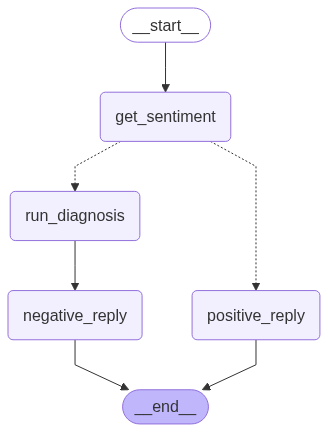

In [23]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())